### set session

In [1]:
name = 'ANA1'
session = '20231211_d21'
num_trials = 143

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import pickle
import glob # find files in a directory
import re # regex for string parsing
from sympy import symbols, diff, Eq, solve

from common.set_matplotlib_settings import set_matplotlib_multiplot_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.select_trials import select_hit_trials
from common.analyze_time_series import make_percent_scaled
from common.extract_movement_intervals import extract_movement_intervals
from jerk.get_jerks import get_jerks, get_point_acceleration
from jerk.calculate_minimum_jerk import solve_x_coefficients, minimum_jerk_function, smoothest_x_function

In [3]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

Velocity_folder = "../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"
PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

respMTX shape: (143, 7)
MTXTrialType shape: (1000, 5)
number of trials: 143


for mac:

In [4]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


for windows:

In [5]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


### calculate jerks for all trials

In [6]:
get_jerks(num_trials, PreprocessLeverData_folder, output_folder)

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$


In [7]:
movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
movement_information = movement_informations[10]

trial_index = int(movement_information[0])
left_index, right_index = movement_information[1:]
left_index = int(left_index)
right_index = int(right_index)
index_a = left_index

leverdata = np.fromfile(PreprocessLeverData_folder+"processed_trial"+str(trial_index)+".bin", dtype=np.double)
index_b = np.argmax(leverdata[left_index:right_index+1]) +left_index
#index_b = right_index

v = np.load(output_folder+"velocity_trial"+str(trial_index)+".npy")
a = np.load(output_folder+"velocity_trial"+str(trial_index)+".npy")

x_0 = leverdata[index_a]
v_0 = v[index_a+1]
a_0 = a[index_a+2]
print(x_0, v_0, a_0)

x_f = leverdata[index_b]
v_f = v[index_b+1]
a_f = a[index_b+2]
print(x_f, v_f, a_f)

sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
tf = sample_times[index_b] - sample_times[index_a]
print("tf:", tf, "s")

3.0328863627468854 5.050921616822965 5.009539932413148
3.0634617744499124 -0.08090140654641216 -0.14007311645581932
tf: 0.011390055399033372 s


Solution for the coefficients:
C1: 69336457.8299980
C2: -228524.103746654
C3: -24853.7206794995
C4: 2.50476996620658
C5: 5.05092161682296
C6: 3.03288636274689
smoothest x sampling frequency:  5794.528445015388


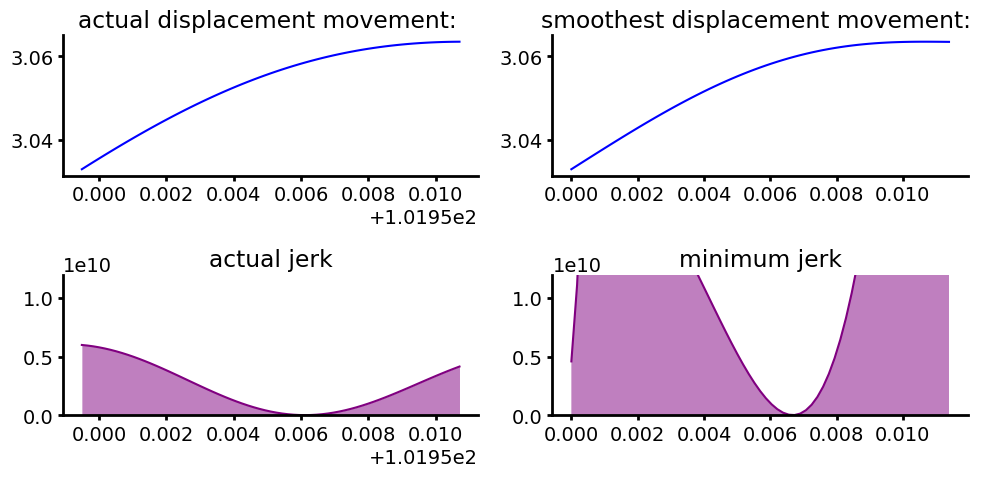

Minimum Cumulative Jerk^2: 216191425.11607617
Actual Cumulative Jerk^2: 26339682.957813676
jerk ratio actual/minimum: 0.12183500313979398


In [8]:
set_matplotlib_multiplot_settings()

smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
t_input = np.linspace(0, tf, index_b - index_a)
print("smoothest x sampling frequency: ", 1/ (np.median(np.diff(t_input))))

plt.subplot(2,2,1)
plt.plot(sample_times[index_a:index_b], leverdata[index_a:index_b], color='blue')
plt.title("actual displacement movement: ")
# plt.ylim([2.5, 3.5])

plt.subplot(2,2,2)
smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)
plt.plot(t_input, smoothest_x, color='blue')
plt.title("smoothest displacement movement: ")
# plt.ylim([2.5, 3.5])


plt.subplot(2, 2, 3)
jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
plt.plot(sample_times[index_a:index_b], jerk[index_a:index_b]**2, color='purple')
plt.fill_between(sample_times[index_a:index_b], 0, jerk[index_a:index_b]**2, color='purple', alpha=0.5, linewidth=0.0)
plt.ylim([0, max(jerk[index_a:index_b]**2)*2])
actual_jerk_dx = np.median(np.diff(sample_times))
actual_cumulative_jerk = np.trapz(jerk[index_a:index_b]**2, dx=actual_jerk_dx)
plt.title("actual jerk")

plt.subplot(2, 2, 4)
minimum_jerk = minimum_jerk_function(smoothest_x, t_input)
minimum_jerk = np.array(minimum_jerk, dtype=float)
plt.plot(t_input, minimum_jerk**2, color='purple')
plt.fill_between(t_input, 0, minimum_jerk**2, color='purple', alpha=0.5, zorder=2, linewidth=0.0)
plt.ylim([0, max(jerk[index_a:index_b]**2)*2])
minimum_jerk_dx = np.median(np.diff(t_input))
minimum_cumulative_jerk = np.trapz(minimum_jerk**2, dx=minimum_jerk_dx)
plt.title("minimum jerk")


plt.show()

print("Minimum Cumulative Jerk^2:", str(minimum_cumulative_jerk))
print("Actual Cumulative Jerk^2:",str(actual_cumulative_jerk))
print("jerk ratio actual/minimum:", actual_cumulative_jerk / minimum_cumulative_jerk)

### Calculate the minimum jerk from peak to end of movement